# The Metropolis-Hastings sampler

Code implementing basic Metropolis-Hastings (see chapter 11 of [Bishop's PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)). 

In [ ]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Defining epsilon for limits
eps = 1e-6
    
# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 3.0
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'cool'

# Fix np.random seed for replicability
np.random.seed(0)

# Metropolis-Hastings algorithm


* input : starting point $x_{cur} \in \mathcal{X}$, the number of samples required $N$
* output : sequence of random variables $x_{0}, x_{1}, \dots x_{N-1}$ from distribution $p$
* Given $x_{cur}$, we generate proposal $x_{prop}$ according to proposal distribution $q(\cdot | x_{cur})$. 
* Set the next state $x_{next}$ as 
$$
\begin{align}
    x_{next} = 
    \begin{cases}
        x_{prop} & (\mbox{with probability } A(x_{prop}, x_{cur})) \\ 
        x_{cur} & (\mbox{with probability } 1 - A(x_{prop}, x_{cur}))
    \end{cases},
\end{align}
$$

where

$$
\begin{align}
    A(x,y) := \min\left( 1, \ \frac{\tilde{p}(x)}{\tilde{p}(y)}\cdot \frac{q(y|x)}{q(x|y)} \right)
\end{align}
$$

For the demo below, we use
* $\mathcal{X}=\mathbb{R}^d$
* proposal distribution: $d$-dimensional gaussian with given covariance matrix $\Sigma$
$$
\begin{align}
    q(x|y) = \frac{1}{(2\pi)^{D/2} \sqrt{\det \Sigma}} \exp\left[ -\frac{1}{2}(x-y)^T \Sigma^{-1} (x-y) \right]
\end{align}
$$

By symmetry of the proposal kernel, the algorithm reduces to Metropolis algorithm, and hence we have
$$
\begin{align}
    A(x,y) := \min\left( 1, \ \frac{\tilde{p}(x)}{\tilde{p}(y)} \right)
\end{align}
$$

In [ ]:
class MetropolisSampler:
    def __init__(self, dim, sigma, p):
        self.dim = dim # the dimension of the output space       
        self.sigma = sigma # the covariance matrix of the Gaussian proposal kernel
        self.p = p # density function of the target distribution
    
    def _A(self, x, y):
        '''
        Acceptance probability, depending on current state y and the candidate state x
        
        Parameters
        ----------
        x : 1D numpy array representing the candidate state
        y : 1D numpy array representing the current state
        Returns 
        ----------
        A : float representing acceptance probability A(x, y)
        '''
        denom = self.p(y)  # for avoiding zero division error
        if denom == 0:
            return 1.0
        else:
            return min( 1.0, self.p(x) / denom )
    
    def sample(self, x_cur, N, step=1):
        '''
        The method that performs sampling using Metropolis algorithm, and returns the samples
        
        Parameters
        ----------
        x_cur : 1D numpy array
            1D numpy array representing current point
        N : int representing number of samples required
        step : int representing step between recorded samples
            
        Returns 
        ----------
        X : 2D array
            (N, self.dim) array representing the obtained samples, where X[n] is the n-th sample.
        '''
        X = np.zeros((N, self.dim))  # array for recording the sample
        x = x_cur
        cnt = 0
        for i in range((N-1) * step + 1):
            x_prop = np.random.multivariate_normal(x, self.sigma)  # sample from the proporsal kernel (gaussian )
            if np.random.random() < self._A(x_prop, x):
                x = x_prop
            if i % step == 0:
                X[cnt] = x
                cnt += 1
        return X

# Demonstrations

We now use MCMC for two exmple applications
* gamma distribution (one dimensional)
* two dimensional gaussian distribution


## Gamma distribution (1-D)

$$
\begin{align}
    & p(x) = \frac{1}{\Gamma(k) \theta^k} x^{k-1} e^{-\frac{x}{\theta}} \\
    & \mbox{mean} : k \theta \\
    & \mbox{variance} : k \theta^2
\end{align}
$$


In [ ]:
def pgam(x):
    if x > 0:
        return (x**2)*np.exp(-x)
    else:
        return 0.0

sampler = MetropolisSampler(dim=1, sigma=np.array([[1.0]]), p=pgam)
samples = sampler.sample(x_cur=np.array([1.0]), N=5000, step=10)

sample mean : 3.0113126471436926
sample variance : 3.020673510476955


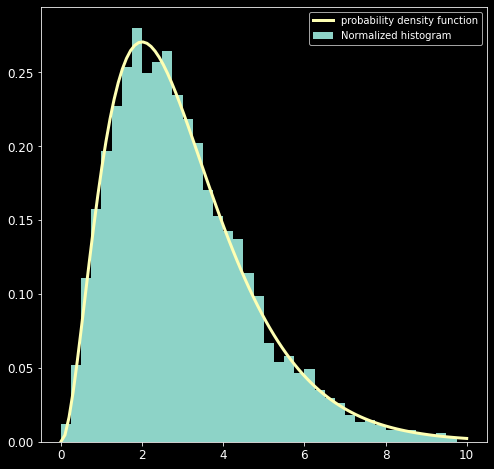

In [ ]:
print(f"sample mean : {np.mean(samples)}")
print(f"sample variance : {np.var(samples)}")
step = 0.25
plt.hist(samples, bins=np.arange(0, 10, step), density=True, label="Normalized histogram")
xx = np.linspace(0,10,100)
plt.plot(xx, 0.5*xx**2*np.exp(-xx), label="probability density function")
plt.legend()
plt.show()

### 2-d Gaussian distribution

$$
\begin{align}
    & p(x) = \frac{1}{2 \pi \sqrt{\det \Sigma}} \exp\left( -\frac{1}{2} x^T \Sigma^{-1} x \right)  \\
    & \Sigma^{-1} = \begin{pmatrix}
    10 & -6  \\
    -6 & 10
    \end{pmatrix} \\
    & \Sigma = 
    \frac{1}{32}
    \begin{pmatrix}
    5 & 3  \\
    3 & 5
    \end{pmatrix}
    = \begin{pmatrix}
    0.15625 & 0.09375  \\
    0.09375 & 0.15625
    \end{pmatrix}
\end{align}
$$


In [ ]:
def p(x):
    precmat = np.array([[10,-6],[-6,10]])
    return np.exp(-0.5*x @ precmat @ x)

sampler = MetropolisSampler(dim = 2, sigma = np.array([[1,0],[0,1]]), p = p)
samples = sampler.sample(np.array([1,0]), N=2000, step=1)

sample mean : [0.0847363  0.02027477]
sample covariance : [[0.17173052 0.1069017 ]
 [0.1069017  0.17045956]]


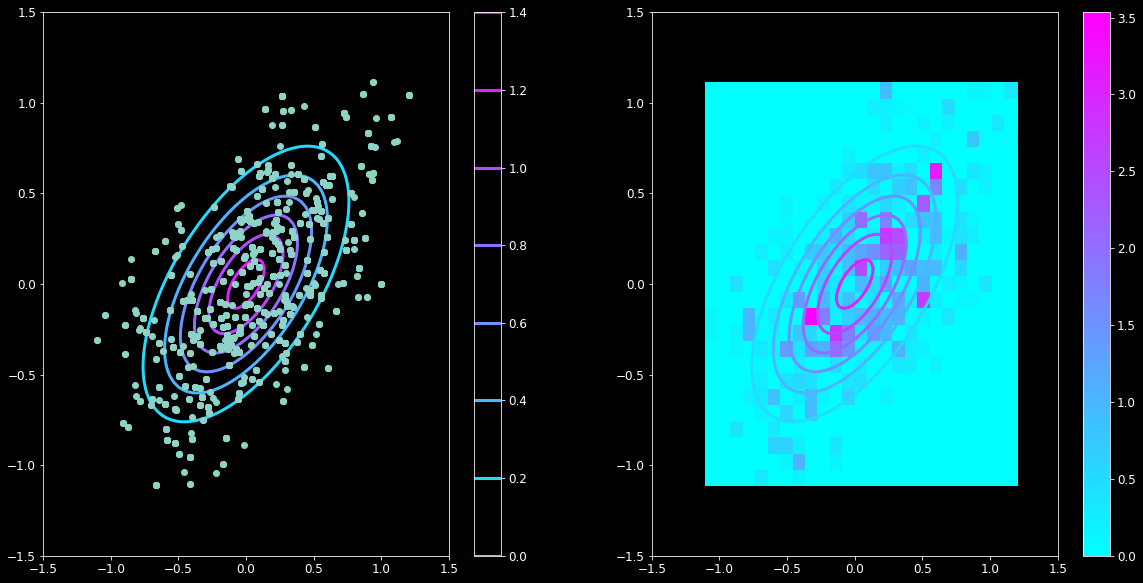

In [ ]:
print(f"sample mean : {np.mean(samples, axis=0)}")
print(f"sample covariance : {np.cov(samples, rowvar=False)}")

# two dimensional histogram
H, xx, yy = np.histogram2d(samples[:,0], samples[:,1], bins=25, normed=True)
H = H.T
XX, YY = np.meshgrid(xx, yy)

# contour plot of the density function
xx_f = np.linspace(-1.5,1.5,100)
yy_f = np.linspace(-1.5,1.5,101)
XX_f, YY_f = np.meshgrid(xx_f, yy_f)
Z_f = np.exp( -0.5*( 10*XX_f*XX_f -12*XX_f*YY_f + 10*YY_f*YY_f ))/(2*np.pi)*8

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(samples[:,0], samples[:,1],'o')
plt.contour(XX_f,YY_f,Z_f)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(XX, YY, H)
plt.colorbar()
plt.contour(XX_f,YY_f,Z_f)
plt.show()